In [2]:
from models.regex import RegexModel
from data_loader import AnnotaionDataLoader
from model_evaluation import ModelEvalWrapper, ModelEvaluator, ModelEvalWrapperInterface

regex_m = RegexModel()
dataloader = AnnotaionDataLoader()
# regex_m.predict(["Unknown function", " ", "Not known", "no data", "\n"])



In [5]:
c_report.cm_display_labels

array([0, 1, 2], dtype=int64)

#####	 Report for Model: fregex	

              precision    recall  f1-score   support

           0       1.00      0.42      0.59       306
           1       0.93      0.64      0.76       134
           2       0.93      1.00      0.96      3060

    accuracy                           0.93      3500
   macro avg       0.96      0.69      0.77      3500
weighted avg       0.94      0.93      0.92      3500

The model took 0.15690 seconds to run

Average time per prediction 0.00004 seconds



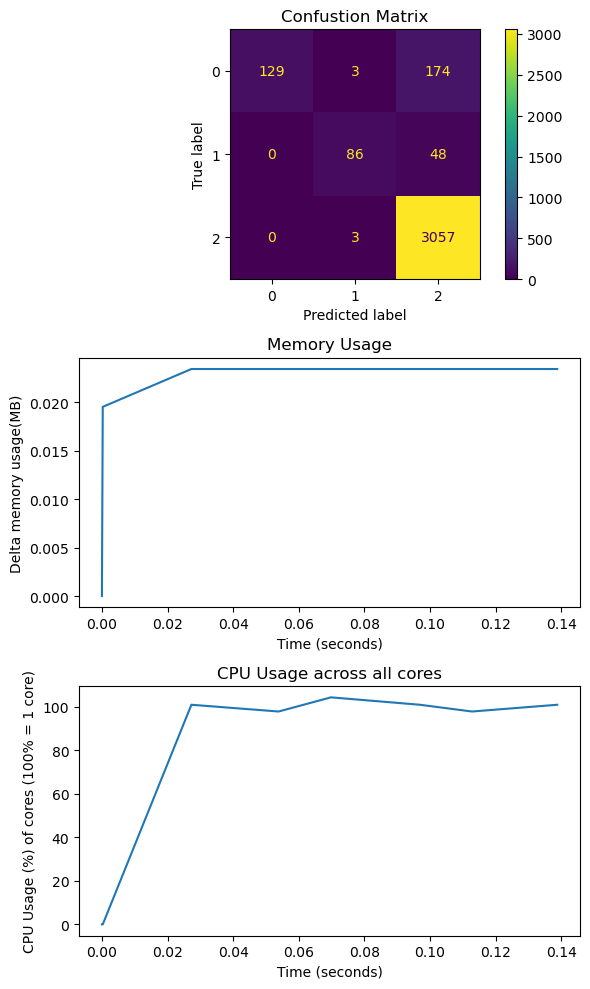

In [3]:
## Evalute model
regex_m_wrapper = ModelEvalWrapper(regex_m, "regex")
m = ModelEvaluator(regex_m_wrapper, dataloader.get_train())

c_report = m.generate_report()
c_report.show_report()
